# Developement of Autogressive Model for Multi-Step predictions


In [ ]:
# TODO: insert illustration

In [ ]:
# import necessary libraries
import importlib.util
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing, metrics
import functools
import operator
#import random
#import time
#import plotly.express as px
#import plotly.graph_objs as go

In [ ]:
# import general Utiltiy Functions Module as gUF
spec = importlib.util.spec_from_file_location("generalUtilityFunctions.py","C:/Users/leonf/Documents/Python/Masterthesis-Leon/Utility_Functions/generalUtilityFunctions.py")
gUF = importlib.util.module_from_spec(spec)
spec.loader.exec_module(gUF)

In [ ]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # if the model should run on CPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
tf.__version__

'2.3.1'

Load the Data

In [ ]:
# Load the specific Dataset
option_data = 12

if option_data == 1: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA_daily.pkl")
    info_data =  "Not Imputed Dataset"
if option_data == 2: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_AVwC.pkl")
    info_data = "AVwC Dataset"
if option_data == 3: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_NRM_d.pkl")
    info_data = "NRM_d Dataset"
if option_data == 4: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_IDW.pkl")
    info_data = "IDW Dataset"
if option_data == 5: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_LR.pkl")
    info_data = "LR Dataset"
if option_data == 6: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA_daily_inside.pkl")
    info_data = "NRM_d Dataset only Stations inside Catchment"
if option_data == 7: # switch to hourly values from here on 
    DATA = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA.pkl')
    info_data = "Hourly Data - Not Imputed"
if option_data == 8: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_AVwC.pkl")
    info_data = "Hourly Data - AVwC"
if option_data == 9: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_NRM_d.pkl")
    info_data = "Hourly Data - NRM_d"
if option_data == 10: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_IDW.pkl")
    info_data = "Hourly Data - IDW"
if option_data == 11: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_LR.pkl")
    info_data = "Hourly Data - LR"
if option_data == 12: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/   v.pkl")
    info_data = "Hourly Data - LR only Stations inside Catchment"

In [ ]:
# Load Larsim Data
data_basis = "hourly"
Larsim_simulations_daily = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/Larsim_simulations_daily.pkl')
Larsim_simulations_hourly = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/Larsim_simulations.pkl')

if data_basis == "daily":
    Larsim_simulations = Larsim_simulations_daily
if data_basis == "hourly":
    Larsim_simulations = Larsim_simulations_hourly

Prepare Input Dataset for the Model


In [ ]:
# choose, if all usable discharge gauges should be used as additional input
with_discharge = False

if with_discharge == False:
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI)
    timestamps = DATA.index.values
    target_feature = ("q", "MARI")
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns="q", level="Parameter")
    model_data = pd.concat([model_data, target_values], axis="columns", join="outer", levels="Parameter")
    # impute missing values in target/ discharge --> linear interpolation
    model_data["q", "MARI"].interpolate(method="time", axis=0, limit=None, inplace=True, limit_direction="both")
    df = model_data.copy()

if with_discharge == True and option_data < 7: # Daily Data
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI))
    timestamps = DATA.index.values
    target_feature = ('q','MARI')
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns='MARI', level='Stationskennung')
    model_data.columns.set_levels(['n', 'q_in', 'rflu', 'tlu_min', 'tlu_max', 'ttau', 'xglob', 'xludr', 'xwind', 'zsos'], level= 0, inplace= True )
    model_data = pd.concat([model_data, target_values], axis='columns', join= 'outer', levels= 'Parameter')
    # impute missing values in target/ discharge --> linear interpolation
    model_data['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
    df = model_data.copy()

if with_discharge == True and option_data >= 7: # Hourly Data
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI))
    timestamps = DATA.index.values
    target_feature = ('q','MARI')
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns='MARI', level='Stationskennung')
    model_data.columns.set_levels(['n', 'q_in', 'rflu', 'tlu', 'ttau', 'xglob', 'xludr', 'xwind', 'zsos'], level= 0, inplace= True )
    model_data = pd.concat([model_data, target_values], axis='columns', join= 'outer', levels= 'Parameter')
    # impute missing values in target/ discharge --> linear interpolation
    model_data['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
    df = model_data.copy()

In [ ]:
# check shape
df.shape

(113736, 29)

In [ ]:
# if option_data < 7:  # Daily Data
#     # General Settings
#     #shuffle_buffer = 10000
#     WINDOW_SIZE = 60  
#     BATCH_SIZE = 20         # higher batch size provides more stability for GPU-Training
#     target_step = 1  

#     # Model Settings
#     num_LSTM_units = 256  
#     EPOCHS = 25  
#     loss_function = 'MAE'    #(options: 'MAE','MSE','NSE')
if option_data >= 7:  # Hourly Data
    # General Settings
    shuffle_buffer = 100000
    WINDOW_SIZE = 120  # --> 5 days lookback
    BATCH_SIZE = 200  
    target_step = 12

    # Model Settings
    num_LSTM_units = 120  
    EPOCHS = 25  
    loss_function = 'MAE'    #(options: 'MAE','MSE','NSE')

In [ ]:
# Splitting the Dataset by Size
training_size = int(len(df) * 0.70)
validation_size = int(len(df) * 0.19)
train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

# Scale the data
scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
train_dataset_scaled = scaler.fit_transform(train_dataset) 
val_dataset_scaled = scaler.transform(val_dataset)
test_dataset_scaled = scaler.transform(test_dataset)

# Fill values after Scaling
fill_value = -7.0
np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

# Retransform the scaled and filled array to dataframe
train_df = pd.DataFrame(data=train_dataset_scaled, index= train_dataset.index, columns= train_dataset.columns)
val_df = pd.DataFrame(data=val_dataset_scaled, index= val_dataset.index, columns= val_dataset.columns)
test_df = pd.DataFrame(data=test_dataset_scaled, index= test_dataset.index, columns= test_dataset.columns)

In [ ]:
# Prepare the larsim simulation data (for the plotting later)
Larsim_train, Larsim_val, Larsim_test = gUF.train_val_test_split(Larsim_simulations['MARI'], (training_size, validation_size), None,  validation=True)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
  
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
#### QUESTION: I am still not able to consider future values (as "forecasted values") in this metehod  !!??

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
multi_step = WindowGenerator(input_width= WINDOW_SIZE, label_width= target_step, shift= target_step, label_columns= None)#[('q','MARI')]

In [ ]:
multi_step

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

In [ ]:
# Choose three example windows
example_window = tf.stack([np.array(train_df[:multi_step.total_window_size]),
                           np.array(train_df[100 : 100 + multi_step.total_window_size]),
                           np.array(train_df[200 : 200 + multi_step.total_window_size])])

In [ ]:
example_window

<tf.Tensor: shape=(3, 48, 29), dtype=float64, numpy=
array([[[-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
         -1.01902705e+00, -5.28227078e-01, -6.36919298e-02],
        [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
         -1.01902705e+00, -5.28227078e-01, -6.36919298e-02],
        [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
         -9.57385638e-01, -5.28227078e-01, -6.36919298e-02],
        ...,
        [ 5.43426465e-01,  1.53605805e+00,  2.01160933e+00, ...,
          7.68573906e-01, -5.28227078e-01, -1.63378927e-01],
        [ 1.52929733e+00,  3.32236546e+00,  1.01923117e+00, ...,
          9.05183710e-02, -5.28227078e-01, -1.63378927e-01],
        [ 6.62925963e-01,  7.98291807e-02, -1.71622626e-01, ...,
          2.75442608e-01, -5.28227078e-01, -1.63378927e-01]],

       [[-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
         -6.49178577e-01, -5.28227078e-01,  2.76606845e-03],
        [-2.18382838e-01, -1.92000208e-01, -1.7162

In [ ]:
# Split the example windows in inputs and labels
example_inputs, example_labels = multi_step.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 29)
Inputs shape: (3, 24, 29)
labels shape: (3, 24, 29)


In [ ]:
# Assign the example windows as attributes of the WindowGenerator Class
multi_step.example = example_inputs, example_labels

In [ ]:
multi_step.example

(<tf.Tensor: shape=(3, 24, 29), dtype=float64, numpy=
 array([[[-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -1.01902705e+00, -5.28227078e-01, -6.36919298e-02],
         [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -1.01902705e+00, -5.28227078e-01, -6.36919298e-02],
         [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -9.57385638e-01, -5.28227078e-01, -6.36919298e-02],
         ...,
         [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -4.02612928e-01, -5.28227078e-01, -8.69522291e-02],
         [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -6.49178577e-01, -5.28227078e-01, -1.03566729e-01],
         [-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -2.17688691e-01, -5.28227078e-01, -1.03566729e-01]],
 
        [[-2.18382838e-01, -1.92000208e-01, -1.71622626e-01, ...,
          -6.49178577e-01, -5.28227078e-01,  2.76606845e-03],
         [-2.18382838e-01, -1.920

In [ ]:
# Crate tf.data. Dataset (Tensor Dataset)
def make_dataset(self, data, batch_size = 32):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size= batch_size,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# The Dataset.element_spec property tells you the structure, dtypes and shapes of the dataset elements.
# Each element is an (inputs, label) pair
multi_step.train.element_spec

(TensorSpec(shape=(None, 24, 29), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 29), dtype=tf.float32, name=None))

In [ ]:
#Iterating over a Dataset yields concrete batches:
for example_inputs, example_labels in multi_step.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 29)
Labels shape (batch, time, features): (32, 24, 29)


In [ ]:
multi_step.train.

<MapDataset shapes: ((None, 24, 29), (None, 24, 29)), types: (tf.float32, tf.float32)>

Autoregressive RNN Model:

In this case the model has to manually manage the inputs for each step so it uses layers.LSTMCell directly for the lower level, single time step interface.

In [ ]:
# Create the autoregressive feedback Class
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell= tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCells in an RNN to simplify the `warmup` method. 
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(29) 

In [ ]:
# Clear Cache and use random seed for reproducability
# tf.keras.backend.clear_session()
# tf.random.set_seed(7)

# Creating a feedback model instance
feedback_model = FeedBack(units= 32 , out_steps= target_step)

In [ ]:
# The first method this model needs is a warmup method to initialize its internal state based on the inputs. Once trained this state will capture the relevant parts of the input history.
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)   # predictions.shape => (batch, features)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
#This method returns a single time-step prediction, and the internal state of the LSTM:
prediction, state = feedback_model.warmup(multi_step.example[0])
prediction.shape  # [batch_size, num_target_features]

TensorShape([32, 29])

In [ ]:
#RNN(with lstm cell) output:
# list of tensors. The first tensor is the output. The remaining tensors are the last states, each with shape [batch_size, state_size], where state_size could be a high dimension tensor shape.
state

[<tf.Tensor: shape=(32, 32), dtype=float32, numpy=
 array([[-0.00830787, -0.41106352, -0.50263935, ...,  0.30131122,
         -0.04878669,  0.16529946],
        [-0.343835  ,  0.06472404,  0.29302502, ...,  0.44010323,
         -0.19492845, -0.24549516],
        [-0.39999944, -0.0729467 ,  0.16873385, ..., -0.03299986,
         -0.20244657, -0.41138408],
        ...,
        [-0.20486134,  0.11102235,  0.25181124, ..., -0.3553967 ,
         -0.21003327, -0.3547754 ],
        [ 0.12454034,  0.28054646,  0.0506362 , ..., -0.34520394,
          0.03200775,  0.09493631],
        [-0.37115535, -0.03151347,  0.1667199 , ...,  0.19304955,
          0.03907261, -0.28174353]], dtype=float32)>,
 <tf.Tensor: shape=(32, 32), dtype=float32, numpy=
 array([[-0.01448774, -1.4089588 , -1.4532777 , ...,  1.0935051 ,
         -0.07628563,  0.37050155],
        [-1.0342085 ,  0.1863222 ,  0.53529584, ...,  0.86946964,
         -0.5592896 , -0.5235959 ],
        [-1.0498102 , -0.17307767,  0.35088408, ...

In [ ]:
# LSTMcell input states:
# List of 2 tensors that corresponding to the cell's units. Both of them have shape [batch, units], the first tensor is the memory state from previous time step, the second tensor is the carry state from previous time step.

With the RNN's state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach to collecting the output predictions is to use a python list, and tf.stack after the loop.

In [ ]:
  def call(self, inputs, training=None):  
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
      # Use the last prediction as input.
      x = prediction

      # Execute one lstm step                                         
      x, state = self.lstm_cell(x, states= state, training= training)  
      prediction = self.dense(x)    # Convert the lstm output to a prediction.
      # Add the prediction to the output
      predictions.append(prediction)

    
    predictions = tf.stack(predictions)  # predictions.shape => (time, batch, features)
    predictions = tf.transpose(predictions, [1, 0, 2]) # predictions.shape => (batch, time, features)
    return predictions

FeedBack.call = call

In [ ]:
#Test run this model on the example inputs:
print('Output shape (batch, time, features): ', feedback_model(multi_step.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 29)


In [ ]:
# Create costum function to crate
def compile_and_fit(model, generated_window, EPOCHS = EPOCHS, loss = loss_function, patience=2):
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')


    if loss == 'NSE':
        loss = gUF.NSE_loss
        observed_metrics = ["mae", "mse", tf.keras.metrics.RootMeanSquaredError()]
    if loss == 'MAE':
        observed_metrics = ["mse", tf.keras.metrics.RootMeanSquaredError()]
    if loss == 'MSE':
        observed_metrics = ["mae", tf.keras.metrics.RootMeanSquaredError()]

    # Compile the Model
    model.compile(loss= loss,
                optimizer="adagrad",
                metrics=observed_metrics)

    # Fit the model 
    history = model.fit(generated_window.train, epochs= EPOCHS, validation_data=generated_window.val, verbose=1)
    
    return history

In [ ]:
# train the model 
history = compile_and_fit(feedback_model, multi_step)

Epoch 1/25
2487/2487 [==============================] - 121s 49ms/step - loss: 0.5508 - mse: 1.1761 - root_mean_squared_error: 1.0845 - val_loss: 0.4979 - val_mse: 1.0902 - val_root_mean_squared_error: 1.0441
Epoch 2/25
2487/2487 [==============================] - 122s 49ms/step - loss: 0.4976 - mse: 1.1351 - root_mean_squared_error: 1.0654 - val_loss: 0.4503 - val_mse: 1.0413 - val_root_mean_squared_error: 1.0204
Epoch 3/25
2487/2487 [==============================] - 111s 45ms/step - loss: 0.4574 - mse: 1.0919 - root_mean_squared_error: 1.0450 - val_loss: 0.4292 - val_mse: 1.0248 - val_root_mean_squared_error: 1.0123
Epoch 4/25
2487/2487 [==============================] - 108s 44ms/step - loss: 0.4409 - mse: 1.0797 - root_mean_squared_error: 1.0391 - val_loss: 0.4204 - val_mse: 1.0221 - val_root_mean_squared_error: 1.0110
Epoch 5/25
2487/2487 [==============================] - 109s 44ms/step - loss: 0.4326 - mse: 1.0762 - root_mean_squared_error: 1.0374 - val_loss: 0.4154 - val_mse: 

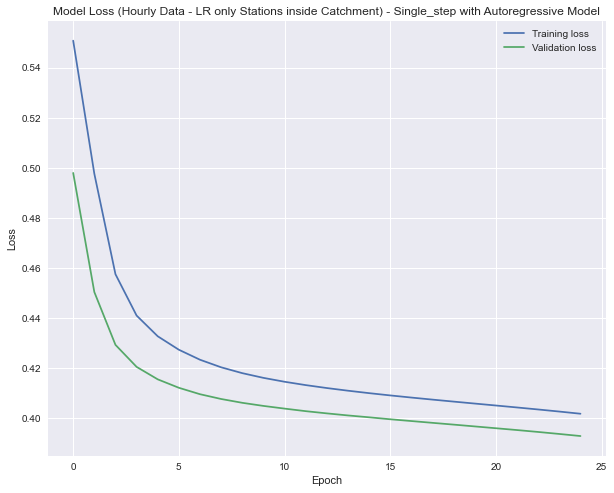

In [ ]:
f = gUF.plot_train_history_normal(history, f"Model Loss ({info_data}) - Single_step with Autoregressive Model")

In [ ]:
# EVALUATION On windowed Datasets (generated by WindowGenerator Class)
# Evaluate the Model -> train_x
print('-------Training----------\n')
# QUESTION: Here I have to change the training call argument right??
results_train = feedback_model.evaluate(multi_step.train, verbose= 0)
result_dict_train = dict(zip(feedback_model.metrics_names, results_train))
for key, value in result_dict_train.items():
  print(key, ":", round(value,5))

print('\n-------Validation----------\n')
# Evaluate the Model -> val_x
results_val = feedback_model.evaluate(multi_step.val, verbose= 0)
result_dict_val = dict(zip(feedback_model.metrics_names, results_val))
for key, value in result_dict_val.items():
  print(key, ":", round(value,5))

print('\n-------Test----------\n')
# Evaluate the Model -> test_x
results_test = feedback_model.evaluate(multi_step.test, verbose= 0)
result_dict_test = dict(zip(feedback_model.metrics_names, results_test))
for key, value in result_dict_test.items():
  print(key, ":", round(value,5))

-------Training----------

loss : 0.40121
mse : 1.04743
root_mean_squared_error : 1.02344

-------Validation----------

loss : 0.39276
mse : 1.0034
root_mean_squared_error : 1.0017

-------Test----------

loss : 0.36859
mse : 0.79063
root_mean_squared_error : 0.88917


In [ ]:
train_df.shape[0] - target_step - WINDOW_SIZE + 1

79568

In [ ]:
def plot(self, model=None, plot_col = ('q','MARI') , max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(25, 10))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Code to compare dimensions with original single shot multi-step model

In [ ]:
    # Splitting the Dataset by Size
    training_size = int(len(df) * 0.70)
    validation_size = int(len(df) * 0.19)
    train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)    
    
    # Scale the data
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    train_dataset_scaled = scaler.fit_transform(train_dataset) 
    val_dataset_scaled = scaler.transform(val_dataset)
    test_dataset_scaled = scaler.transform(test_dataset)

    # Fill values after Scaling
    fill_value = -7.0
    np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

    # Split Training/Validation/Test Dataset into input features and target values/labels
    train_x, train_y = gUF.windowed_data(train_dataset_scaled, train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=False)
    val_x, val_y = gUF.windowed_data(val_dataset_scaled, val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=False)
    test_x, test_y = gUF.windowed_data(test_dataset_scaled, test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=False)

    # Combine resulting features and lables into one Tensor consisting of shuffled batches
    training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=True)
    validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=True)
    testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=True)

In [ ]:
# check Dimensions

# train_dataset --> complete Training Dataset after splitting 
print(len(train_dataset))

# val_dataset --> dataset used for validation during fitting of the model
print(len(val_dataset)) # resulting period (i.e. how often do the window fit completetly into the training data): length of the training data - window-size - 1

# test_dataset --> complete Testing Dataset after splitting
print(len(test_dataset))

# check lengths
print('Sum:',len(test_dataset) + len(val_dataset) + len(train_dataset)) # must be equal to the time period of the complete input dataframe
print('_____________________________________')
print(train_x.shape) #(resulting period, window_size, # of input features)
print(val_x.shape) #(resulting period, window_size, # of input features)
print(test_x.shape) #(resulting period, window_size, # of input features)
print('_____________________________________')
# Get coorect input shape for the first layer of the NN
# for LSTM (window_size, # features)
SHAPE = train_x.shape[-2:] 
print('Input_Shape for LSTM:',SHAPE)

79615
21609
12512
Sum: 113736
_____________________________________
(79484, 120, 29)
(21478, 120, 29)
(12381, 120, 29)
_____________________________________
Input_Shape for LSTM: (120, 29)
